Nathan Deinlein <br>
Ryan Kinney <br>
Chris Roche <br>
Cameron Stewart <br>

# Machine Learning 1 - Lab 3 Clustering

## Section 1: Business Understanding 1

Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?

...

## Section 2: Data Understanding 1

Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

...

### Sub-Section 1.1: Load in and Prepare Data

#### Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics as mt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, roc_auc_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#### Read in data

In [2]:
url = "https://raw.githubusercontent.com/nedeinlein/Machine_Learning_I/main/runs_clean.csv"
runs_df = pd.read_csv(url, index_col=False)
print('Data set shape:',runs_df.shape)
runs_df.head()

Data set shape: (79423, 29)


,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,behind_sec2,behind_sec3,time1,time2,time3,finish_time,win_odds,place_odds,trainer_id,jockey_id
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,2.00,1.50,13.85,21.59,23.86,83.92,9.7,3.7,118,2
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,9.00,5.00,14.57,21.99,23.30,83.56,16.0,4.9,164,57
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,1.00,0.75,13.69,21.59,23.90,83.40,3.5,1.5,137,18
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,5.00,3.50,14.09,21.83,23.70,83.62,39.0,11.0,80,59
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,8.75,4.25,14.77,21.75,23.22,83.24,50.0,14.0,9,154


#### Create Show Variable

In [3]:
runs_df['show'] = np.where(runs_df['result'] <= 3, 1, 0)
runs_df.head()

,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,behind_sec3,time1,time2,time3,finish_time,win_odds,place_odds,trainer_id,jockey_id,show
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,1.50,13.85,21.59,23.86,83.92,9.7,3.7,118,2,0
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,5.00,14.57,21.99,23.30,83.56,16.0,4.9,164,57,0
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,0.75,13.69,21.59,23.90,83.40,3.5,1.5,137,18,0
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,3.50,14.09,21.83,23.70,83.62,39.0,11.0,80,59,0
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,4.25,14.77,21.75,23.22,83.24,50.0,14.0,9,154,0


#### Remove variables that are not needed/useful for the analysis

In [4]:
runs_data = runs_df.drop(['Unnamed: 0','race_id','horse_id','result','won','lengths_behind','horse_gear','position_sec1','position_sec2','position_sec3','behind_sec1','behind_sec2','behind_sec3','time1','time2','time3','finish_time','trainer_id','jockey_id','show'], axis=1)
runs_target = runs_df['won']
runs_target2 = runs_df['show']
print('Predictor data set shape after dropping non-important predictors \nand separating response variables into their own data sets: \n',runs_data.shape)
runs_data.head()

Predictor data set shape after dropping non-important predictors 
and separating response variables into their own data sets: 
 (79423, 10)


,horse_no,horse_age,horse_country,horse_type,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds
0,1,3,AUS,Gelding,60,1020.0,133,7,9.7,3.7
1,2,3,NZ,Gelding,60,980.0,133,12,16.0,4.9
2,3,3,NZ,Gelding,60,1082.0,132,8,3.5,1.5
3,4,3,SAF,Gelding,60,1118.0,127,13,39.0,11.0
4,5,3,GB,Gelding,60,972.0,131,14,50.0,14.0


#### One-Hot Encode Categorical Variables

In [5]:
tmp_df = pd.get_dummies(runs_data.horse_country,prefix='horse_country')
runs_df_onehot = pd.concat((runs_data,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(runs_data.horse_type,prefix='horse_type')
runs_df_onehot = pd.concat((runs_df_onehot,tmp_df),axis=1) # add back into the dataframe

runs_data = runs_df_onehot.reset_index(drop=True)
runs_data = runs_data.drop(['horse_country','horse_type'], axis=1)

print('Shape after One-Hot Encoding Categorical Predictors:',runs_data.shape)
runs_data.head()

Shape after One-Hot Encoding Categorical Predictors: (79423, 33)


,horse_no,horse_age,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds,horse_country_ARG,horse_country_AUS,...,horse_country_ZIM,horse_type_Brown,horse_type_Colt,horse_type_Filly,horse_type_Gelding,horse_type_Grey,horse_type_Horse,horse_type_Mare,horse_type_Rig,horse_type_Roan
0,1,3,60,1020.0,133,7,9.7,3.7,0,1,...,0,0,0,0,1,0,0,0,0,0
1,2,3,60,980.0,133,12,16.0,4.9,0,0,...,0,0,0,0,1,0,0,0,0,0
2,3,3,60,1082.0,132,8,3.5,1.5,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,3,60,1118.0,127,13,39.0,11.0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,5,3,60,972.0,131,14,50.0,14.0,0,0,...,0,0,0,0,1,0,0,0,0,0


## Section 3: Data Understanding 2

Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

...

#### Win Odds and Horse Country

The following graph plots the country of origin for the horse and it's win odds. There is some relationship between a horse's country of origin and it's win odds. Particularly, horses from Australia and Ne Zealand tend to have really good odds. Horses from Canada, Italy, Argentina tend to have lower odds but also a wider distribution.

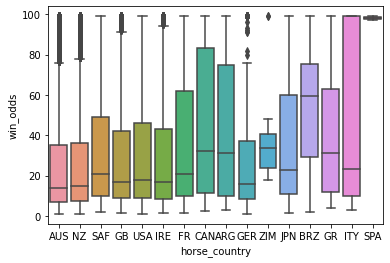

In [6]:
sns.boxplot(x="horse_country",y="win_odds",data=runs_df)
plt.show()

#### Win Odds and Horse Type

Next, we looked at horse type, which based on previous labs tended to be an important feature. Geldings, Browns, and Greys had smaller distributions of win odds. Geldings had the best odds on average. Ris, Colts, and Fillys would be less sure bets based on the distribution of odds for those types of horses.

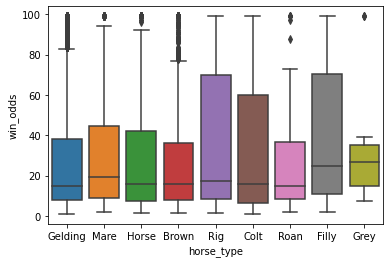

In [7]:
sns.boxplot(x="horse_type",y="win_odds",data=runs_df)
plt.show()

#### Win Odds and Finish Place

Based on previous labs, far and away the most important feature in determining a result was the horse's win odds. The graph below plots that relationship. As can be seen, there is a strong relationship. Horses with better odds were not only more likely to win (based on mean) but had much smaller distributions. Intuitively, this makes sense. Horse odds are set by professionals who have the best information and insight into the chances a horse will win a particular race.

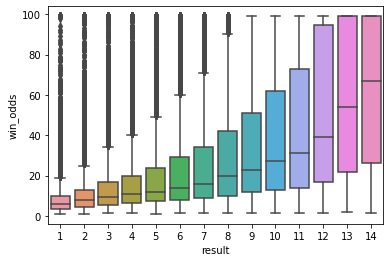

In [8]:
sns.boxplot(x='result', y='win_odds', data=runs_df)
plt.show()

#### Place Odds and Finish Position

Similarly to win odds, we plotted place odds against result. As would be expected, the relationship is very similar to win odds. In fact the range of distribution is smaller. That makes sense since win is determined by a horse finishing in a single position (1) whereas place is the horse finishing in first through third, so it is more forgiving. 

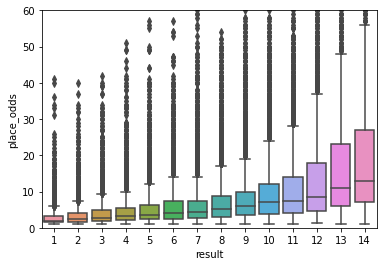

In [9]:
sns.boxplot(x='result', y='place_odds', data=runs_df)
plt.ylim(0,60)
plt.show()

#### Draw and Finish Position

The draw of a horse is random. Which horse begins the race in which stall is not determined by win odds or any other factor. It's a well known fact in racing that the "inside" track is preferred since it reduces the overall distance you have to travel. Therefore it intuitively makes sense that a horse beginning the race inside (draw 1) would have a slightly better chance in the race.

The chart below backs this up, to an extent. It is clear that the higher draw a hhorse has (the further from pole position they begin), the worse result they have on average.

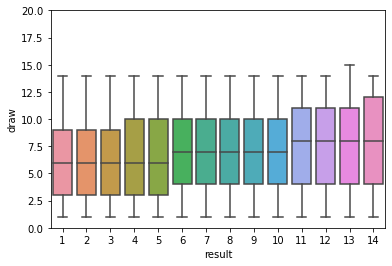

In [10]:
sns.boxplot(x='result', y='draw', data=runs_df)
plt.ylim(0,20)
plt.show()

#### Win Odds vs Result with Confidence Interval

Since it is clear there is a strong relationship between a horse's win or place odds and their result, we took another look at that relationship in another way.

The two plots below show the linear relationship between win odds an result, and place odds and result, with confidence intervals. Note how small he intervals. As the odds for a horse get worse, the interval gets larger, but only slightly. 

<AxesSubplot:xlabel='result', ylabel='win_odds'>

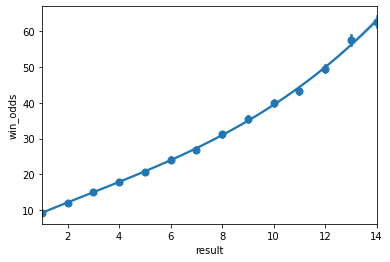

In [11]:
sns.regplot(x="result", y="win_odds", data=runs_df, x_estimator=np.mean, order=3)

#### Place Odds vs Result with Confidence Interval

Refer to the description above.

<AxesSubplot:xlabel='result', ylabel='place_odds'>

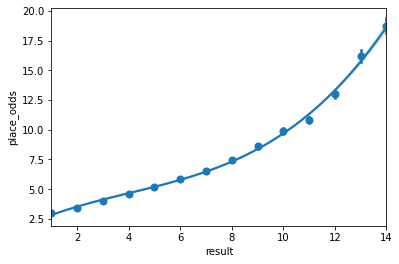

In [12]:
sns.regplot(x="result", y="place_odds", data=runs_df, x_estimator=np.mean, order=3)

#### Draw vs Result with Confidence Interval

Again, we plotted the linear relationship. This time between draw and result. We showed earlier their is a relationship between draw and result, but you could see it was not as strong as the relationship between win or place odds and result.

The confidence intervals for the below plot support the claim that the relationship is not as strong. The confidence intervals are not nearly as tight, meaning their is a wider distribution. So, the draw is an important feature in result, but it is not as much of a "sure thing" as win or place odds.

<AxesSubplot:xlabel='result', ylabel='draw'>

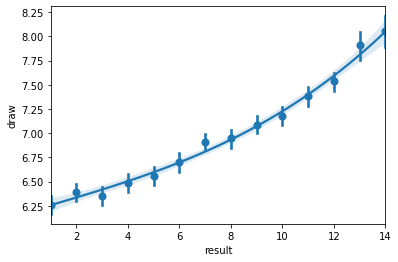

In [13]:
sns.regplot(x="result", y="draw", data=runs_df, x_estimator=np.mean, order=3)

#### Win Odds vs Place Odds, by Result

The last plot we chose to include in this report is a scatterplot showing win odds vs. place odds, categorized by result. The lighter the color, the better result, or finishing position. The darker the color, the worse the result.

It is clear, on the bottom-left of the graph the data points are lighter. In other words, a horse with lower win and place odds tends to finish the race in a better position. 

For this we filtered the data set for place odds of less than 30:1. There are a large number of outliers that make the plot less clear to read. We included the unfiltered plot below, for reference.

<AxesSubplot:xlabel='win_odds', ylabel='place_odds'>

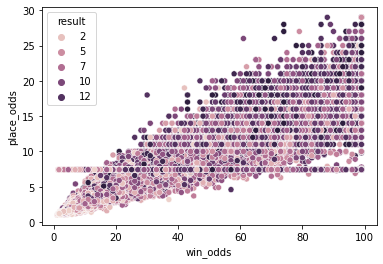

In [14]:
runs_df_lower_odds = runs_df[runs_df['place_odds'] < 30] 
sns.scatterplot(x='win_odds', y='place_odds', hue='result', data=runs_df_lower_odds)

#### Same plot but unfiltered for outliers

<AxesSubplot:xlabel='win_odds', ylabel='place_odds'>

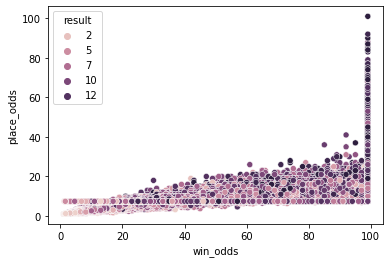

In [15]:
sns.scatterplot(x='win_odds', y='place_odds', hue='result', data=runs_df)

## Section 4: Modeling and Evaluation 1

### Section 4.1 K-Means Clustering

For the first K-means model, we used all parameters from the train data set. We put the model in a for-loop and incremented the number of clusters from 2 to 20. For each iteration we recorded the AUC and precision of the model to compare. Since we elected to use AUC as our primary metric, the model with 9 clusters performed the best

In [16]:
X_train,X_test,Y_train,Y_test = train_test_split(runs_data,runs_target,test_size=0.20,random_state=0)

#### KMeans Full - all features

In [17]:
best_auc_cluster = 0
best_auc = 0

for x in range(2,20):
    
    kmeans = KMeans(
        init='k-means++',  # initialization
        n_clusters=x,      # number of clusters
        n_init=10,         # number of different times to run k-means
        algorithm='full')
        
    kmeans.fit(X_train)

    yhat= kmeans.predict(X_test)
    prec = mt.precision_score(Y_test,yhat,average='micro')
    auc = roc_auc_score(Y_test,yhat)
    if (auc > best_auc):
        best_auc = auc
        best_auc_cluster = x
    print('Precision is: %.3f'%(prec), ' AUC: %.3f'%auc, ' for clusters=',x)

print('Best AUC: %.3f'%(best_auc), ' for clusters=',best_auc_cluster)

Precision is: 0.551  AUC: 0.523  for clusters= 2
Precision is: 0.438  AUC: 0.484  for clusters= 3
Precision is: 0.255  AUC: 0.519  for clusters= 4
Precision is: 0.242  AUC: 0.507  for clusters= 5
Precision is: 0.252  AUC: 0.426  for clusters= 6
Precision is: 0.245  AUC: 0.435  for clusters= 7
Precision is: 0.104  AUC: 0.477  for clusters= 8
Precision is: 0.168  AUC: 0.514  for clusters= 9
Precision is: 0.093  AUC: 0.504  for clusters= 10
Precision is: 0.064  AUC: 0.484  for clusters= 11
Precision is: 0.061  AUC: 0.527  for clusters= 12
Precision is: 0.148  AUC: 0.495  for clusters= 13
Precision is: 0.097  AUC: 0.499  for clusters= 14
Precision is: 0.055  AUC: 0.484  for clusters= 15
Precision is: 0.029  AUC: 0.446  for clusters= 16
Precision is: 0.099  AUC: 0.499  for clusters= 17
Precision is: 0.019  AUC: 0.476  for clusters= 18
Precision is: 0.106  AUC: 0.462  for clusters= 19
Best AUC: 0.527  for clusters= 12


#### KMeans Elkan - all features

Next, we re-ran the same model as above but changed the sklearn KMeans algorithm parameter from the default (full) to "elkan". According to the sklearn documentation, elkan is best suited for data with well defined clusters. For this model, we did not believe that to be the case but ran the model anyway. The model not only took longer to train but it did not achieve as high of an AUC score as the previous "full" model.

In [18]:
best_auc_cluster = 0
best_auc = 0

for x in range(2,20):
    
    kmeans = KMeans(
        init='k-means++',  # initialization
        n_clusters=x,      # number of clusters
        n_init=10,         # number of different times to run k-means
        algorithm='elkan')

    kmeans.fit(X_train)

    yhat= kmeans.predict(X_test)
    prec = mt.precision_score(Y_test,yhat,average='micro')
    auc = roc_auc_score(Y_test,yhat)
    if (auc > best_auc):
        best_auc = auc
        best_auc_cluster = x
    print('Precision is: %.3f'%(prec), ' AUC: %.3f'%auc, ' for clusters=',x)
    
print('Best AUC: %.3f'%(best_auc), ' for clusters=',best_auc_cluster)

Precision is: 0.551  AUC: 0.523  for clusters= 2
Precision is: 0.266  AUC: 0.473  for clusters= 3
Precision is: 0.370  AUC: 0.415  for clusters= 4
Precision is: 0.316  AUC: 0.419  for clusters= 5
Precision is: 0.222  AUC: 0.457  for clusters= 6
Precision is: 0.117  AUC: 0.419  for clusters= 7
Precision is: 0.121  AUC: 0.482  for clusters= 8
Precision is: 0.195  AUC: 0.529  for clusters= 9
Precision is: 0.139  AUC: 0.456  for clusters= 10
Precision is: 0.068  AUC: 0.496  for clusters= 11
Precision is: 0.154  AUC: 0.453  for clusters= 12
Precision is: 0.063  AUC: 0.479  for clusters= 13
Precision is: 0.129  AUC: 0.487  for clusters= 14
Precision is: 0.063  AUC: 0.493  for clusters= 15
Precision is: 0.140  AUC: 0.468  for clusters= 16
Precision is: 0.020  AUC: 0.491  for clusters= 17
Precision is: 0.034  AUC: 0.480  for clusters= 18
Precision is: 0.020  AUC: 0.533  for clusters= 19
Best AUC: 0.533  for clusters= 19


#### KMeans - Win and Place Odds

From the data exploration we performed in Section 3 of this report as well as previous reports, we know the most important features in the data set for predicting winners and losers to be Win Odds and Place Odds.

For this K-means model, we ran with only those predictors included in the training data to visualize the clustering and compare the performance to the previous models.

In [19]:
win_place_train=X_train.iloc[:,[6,7]] # Create an array with win odds, place odds
win_place_test=X_test.iloc[:,[6,7]]   # Create an array with win odds, place odds

In [20]:
best_auc_cluster = 0
best_auc = 0

for x in range(2,20):

    kmeans_mini = MiniBatchKMeans(n_clusters=x, batch_size=10,random_state=0)
    kmeans = KMeans(n_clusters=x,random_state=0)

    kmeans.fit(win_place_train)
    kmeans_mini.fit(win_place_train)

    yhat= kmeans.predict(win_place_test)
    prec = mt.precision_score(Y_test,yhat,average='micro')
    auc = roc_auc_score(Y_test,yhat)
    if (auc > best_auc):
        best_auc = auc
        best_auc_cluster = x
    print('KMeans Precision is: %.3f'%(prec), ' AUC: %.3f'%auc, ' for clusters=',x)

    yhat= kmeans_mini.predict(win_place_test)
    prec = mt.precision_score(Y_test,yhat,average='micro')
    auc = roc_auc_score(Y_test,yhat)
    if (auc > best_auc):
        best_auc = auc
        best_auc_cluster = x
    print('KMeans Mini Precision is: %.3f'%(prec), ' AUC: %.3f'%auc, ' for clusters=',x)
    print('')
    
print('Best AUC: %.3f'%(best_auc), ' for clusters=',best_auc_cluster)

KMeans Precision is: 0.726  AUC: 0.401  for clusters= 2
KMeans Mini Precision is: 0.721  AUC: 0.399  for clusters= 2

KMeans Precision is: 0.265  AUC: 0.509  for clusters= 3
KMeans Mini Precision is: 0.580  AUC: 0.346  for clusters= 3

KMeans Precision is: 0.206  AUC: 0.585  for clusters= 4
KMeans Mini Precision is: 0.165  AUC: 0.713  for clusters= 4

KMeans Precision is: 0.216  AUC: 0.598  for clusters= 5
KMeans Mini Precision is: 0.521  AUC: 0.331  for clusters= 5

KMeans Precision is: 0.179  AUC: 0.401  for clusters= 6
KMeans Mini Precision is: 0.129  AUC: 0.369  for clusters= 6

KMeans Precision is: 0.118  AUC: 0.462  for clusters= 7
KMeans Mini Precision is: 0.078  AUC: 0.686  for clusters= 7

KMeans Precision is: 0.307  AUC: 0.299  for clusters= 8
KMeans Mini Precision is: 0.138  AUC: 0.341  for clusters= 8

KMeans Precision is: 0.064  AUC: 0.527  for clusters= 9
KMeans Mini Precision is: 0.123  AUC: 0.693  for clusters= 9

KMeans Precision is: 0.089  AUC: 0.601  for clusters= 10

After running the above model for all numbers of clusters from 2 to 20, we determined the number of clusters that produced the best AUC.

With that, we re-ran the model and plotted the results so we could visualize the performance. If you recall the Win Odds vs Place Odds scatterplot from Section 3 Data Understanding, the below will look very familiar. Instead of coloring each point based on Result (place the horse finished), the data points are colored by the cluster they were placed in.

We plot both the results from KMeans and KMeans Mini-Batch.

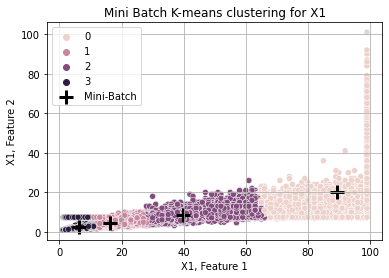

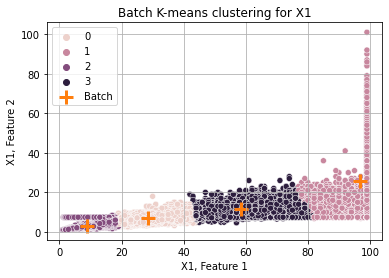

In [21]:
kmeans_mini = MiniBatchKMeans(n_clusters=best_auc_cluster, batch_size=10,random_state=0)
kmeans = KMeans(n_clusters=best_auc_cluster,random_state=0)

kmeans.fit(win_place_train)
kmeans_mini.fit(win_place_train)
    
c_mini=kmeans_mini.labels_
sns.scatterplot(win_place_train.iloc[:, 0], win_place_train.iloc[:, 1], hue=c_mini)
centroids = kmeans_mini.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, color='k',label='Mini-Batch')
plt.legend()
plt.title('Mini Batch K-means clustering for X1')
plt.xlabel('X1, Feature 1')
plt.ylabel('X1, Feature 2')
plt.grid()
plt.show()

c_means=kmeans.labels_
sns.scatterplot(win_place_train.iloc[:, 0], win_place_train.iloc[:, 1], hue=c_means)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='+', s=200, linewidths=3, label='Batch')
plt.legend()
plt.title('Batch K-means clustering for X1')
plt.xlabel('X1, Feature 1')
plt.ylabel('X1, Feature 2')
plt.grid()
plt.show()

As we discussed in Section 3, if we filter the Place Odds for only those with odds of less than 30:1, to data plots much cleaner. Next, we filtered the data similarly and created models with it to compare to the unfiltered model.

In terms of model deployment, this is not very useful. If you are gambling the most money is to be made on higher longer odds bets. Additionally, we do not have a statistical reason to filter out these "outliers".

In [22]:
runs_df_lower_odds

runs_data_sub = runs_df_lower_odds.drop(['Unnamed: 0','race_id','horse_id','result','won','lengths_behind','horse_gear','position_sec1','position_sec2','position_sec3','behind_sec1','behind_sec2','behind_sec3','time1','time2','time3','finish_time','trainer_id','jockey_id','show'], axis=1)
runs_target_sub = runs_df_lower_odds['won']

X_train_sub,X_test_sub,Y_train_sub,Y_test_sub = train_test_split(runs_data_sub,runs_target_sub,test_size=0.20,random_state=0)

win_place_train_odds_sub=X_train_sub.iloc[:,[6,7]] # Create an array with win odds, place odds
win_place_test_odds_sub=X_test_sub.iloc[:,[6,7]]   # Create an array with win odds, place odds

In [23]:
est_auc_cluster = 0
best_auc = 0

for x in range(2,20):
    
    kmeans_mini = MiniBatchKMeans(n_clusters=x, batch_size=10,random_state=0)
    kmeans = KMeans(n_clusters=x,random_state=0)

    kmeans.fit(win_place_train_odds_sub)
    kmeans_mini.fit(win_place_train_odds_sub)

    yhat= kmeans.predict(win_place_test_odds_sub)
    prec = mt.precision_score(Y_test_sub,yhat,average='micro')
    auc = roc_auc_score(Y_test_sub,yhat)
    if (auc > best_auc):
        best_auc = auc
        best_auc_cluster = x
    print('KMeans Precision is: %.3f'%(prec), ' AUC: %.3f'%auc, ' for clusters=',x)

    yhat= kmeans_mini.predict(win_place_test_odds_sub)
    prec = mt.precision_score(Y_test_sub,yhat,average='micro')
    auc = roc_auc_score(Y_test_sub,yhat)
    if (auc > best_auc):
        best_auc = auc
        best_auc_cluster = x
    print('KMeans Mini Precision is: %.3f'%(prec), ' AUC: %.3f'%auc, ' for clusters=',x)
    print('')

print('Best AUC: %.3f'%(best_auc), ' for clusters=',best_auc_cluster)

KMeans Precision is: 0.529  AUC: 0.464  for clusters= 2
KMeans Mini Precision is: 0.471  AUC: 0.536  for clusters= 2

KMeans Precision is: 0.285  AUC: 0.542  for clusters= 3
KMeans Mini Precision is: 0.335  AUC: 0.537  for clusters= 3

KMeans Precision is: 0.252  AUC: 0.497  for clusters= 4
KMeans Mini Precision is: 0.243  AUC: 0.440  for clusters= 4

KMeans Precision is: 0.177  AUC: 0.555  for clusters= 5
KMeans Mini Precision is: 0.210  AUC: 0.483  for clusters= 5

KMeans Precision is: 0.188  AUC: 0.481  for clusters= 6
KMeans Mini Precision is: 0.183  AUC: 0.475  for clusters= 6

KMeans Precision is: 0.127  AUC: 0.506  for clusters= 7
KMeans Mini Precision is: 0.172  AUC: 0.466  for clusters= 7

KMeans Precision is: 0.146  AUC: 0.513  for clusters= 8
KMeans Mini Precision is: 0.170  AUC: 0.473  for clusters= 8

KMeans Precision is: 0.142  AUC: 0.522  for clusters= 9
KMeans Mini Precision is: 0.144  AUC: 0.471  for clusters= 9

KMeans Precision is: 0.116  AUC: 0.511  for clusters= 10

Surprisingly, this model performed much worse than the unfiltered model. This is most likely because observations with Place Odds of greater than 30:1 make up a large part of the data set, therefore we had less to train on. However, one would have thought removing more "extreme" points would have made up for that.

Since the model performed poorly and is not useful, we do not show the plots here.

## Section 5: Modeling and Evaluation 2

Evaluate and Compare

...

## Section 6: Modeling and Evaluation 3

Visualize Results

...

## Section 7: Modeling and Evaluation 4

Summarize the Ramifications

...

## Section 8: Deployment

Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?

...

## Section 9: Exceptional Work

You have free reign to provide additional analyses or combine analyses.

...